# Training and evaluating the models

In [1]:
!\cp *.py aws

In [1]:
!pip install -r requirements.txt --quiet

fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Setup

In [2]:
# plotting
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [4]:
import torch 
from dl_utils import *
from models import *
from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}!')

IMG_SIZE = 224

Running on cpu!


In [5]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

In [6]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

## Data

In [7]:
# # iterate through S3 objects and print contents
# counter = 0
# for obj in boto3.resource('s3').Bucket(bucket).objects.all():
#     if counter == 10:
#         break
#     print(obj.key)
#     counter += 1

In [8]:
input_data = 's3://sagemaker-eu-west-1-873555039102/images'

## Training

### V0

In [10]:
# specify an output path
prefix = 'model_v0'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train_color_cnn.py',
                    source_dir='aws', 
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'model-version': 'ColorCNN_v0',
                        'lab-version': 1
                    })

In [12]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

2020-04-14 14:34:05 Starting - Starting the training job...
2020-04-14 14:34:06 Starting - Launching requested ML instances......
2020-04-14 14:35:06 Starting - Preparing the instances for training......
2020-04-14 14:36:10 Downloading - Downloading input data.........
2020-04-14 14:37:47 Training - Downloading the training image......
2020-04-14 14:38:50 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-14 14:38:51,593 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-14 14:38:51,618 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-14 14:38:53,062 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-14 14:38:53,335 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020

In [14]:
# specify all the paths 
DEST_PATH = 'results/model_v0'
FROM_PATH = 'model_v0/pytorch-training-2020-04-14-14-34-04-829/output/model.tar.gz'
TO_PATH = os.path.join(DEST_PATH, 'model.tar.gz')
CHECKPOINT_PATH = os.path.join(DEST_PATH, 'model_best.pth.tar')

os.makedirs(DEST_PATH)

In [15]:
# download the data from S3
boto3.resource('s3').Bucket(bucket).download_file(FROM_PATH, TO_PATH)

# unpack the zip 
shutil.unpack_archive(TO_PATH, DEST_PATH)

# load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))

# instantiate the model and load the state dict for inference
model = ColorCNN_v0(lab_version=checkpoint['lab_version']).to(device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

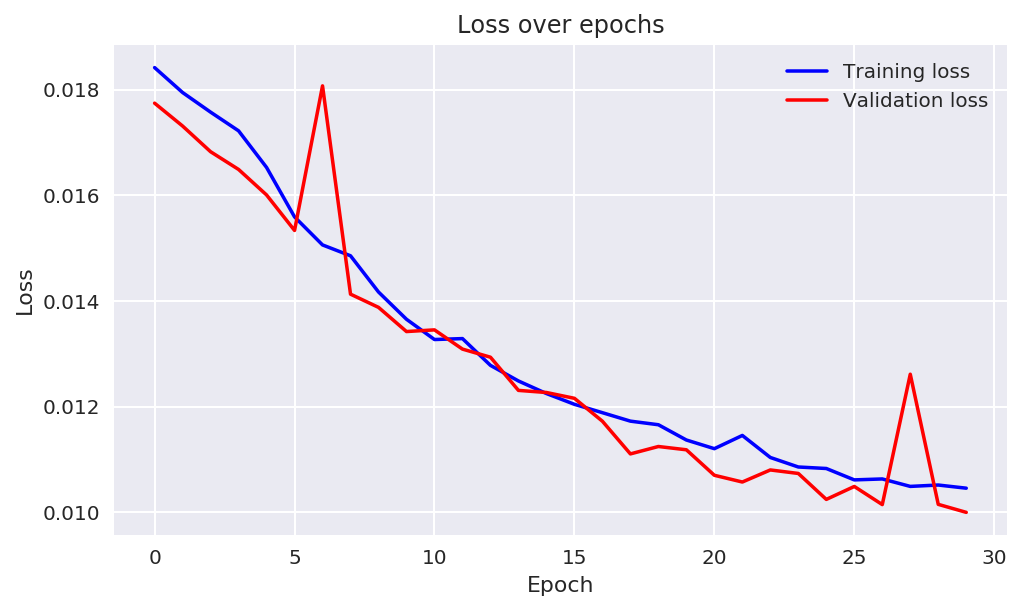

In [16]:
# plot the losses 
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']
plot_losses(train_losses, valid_losses)

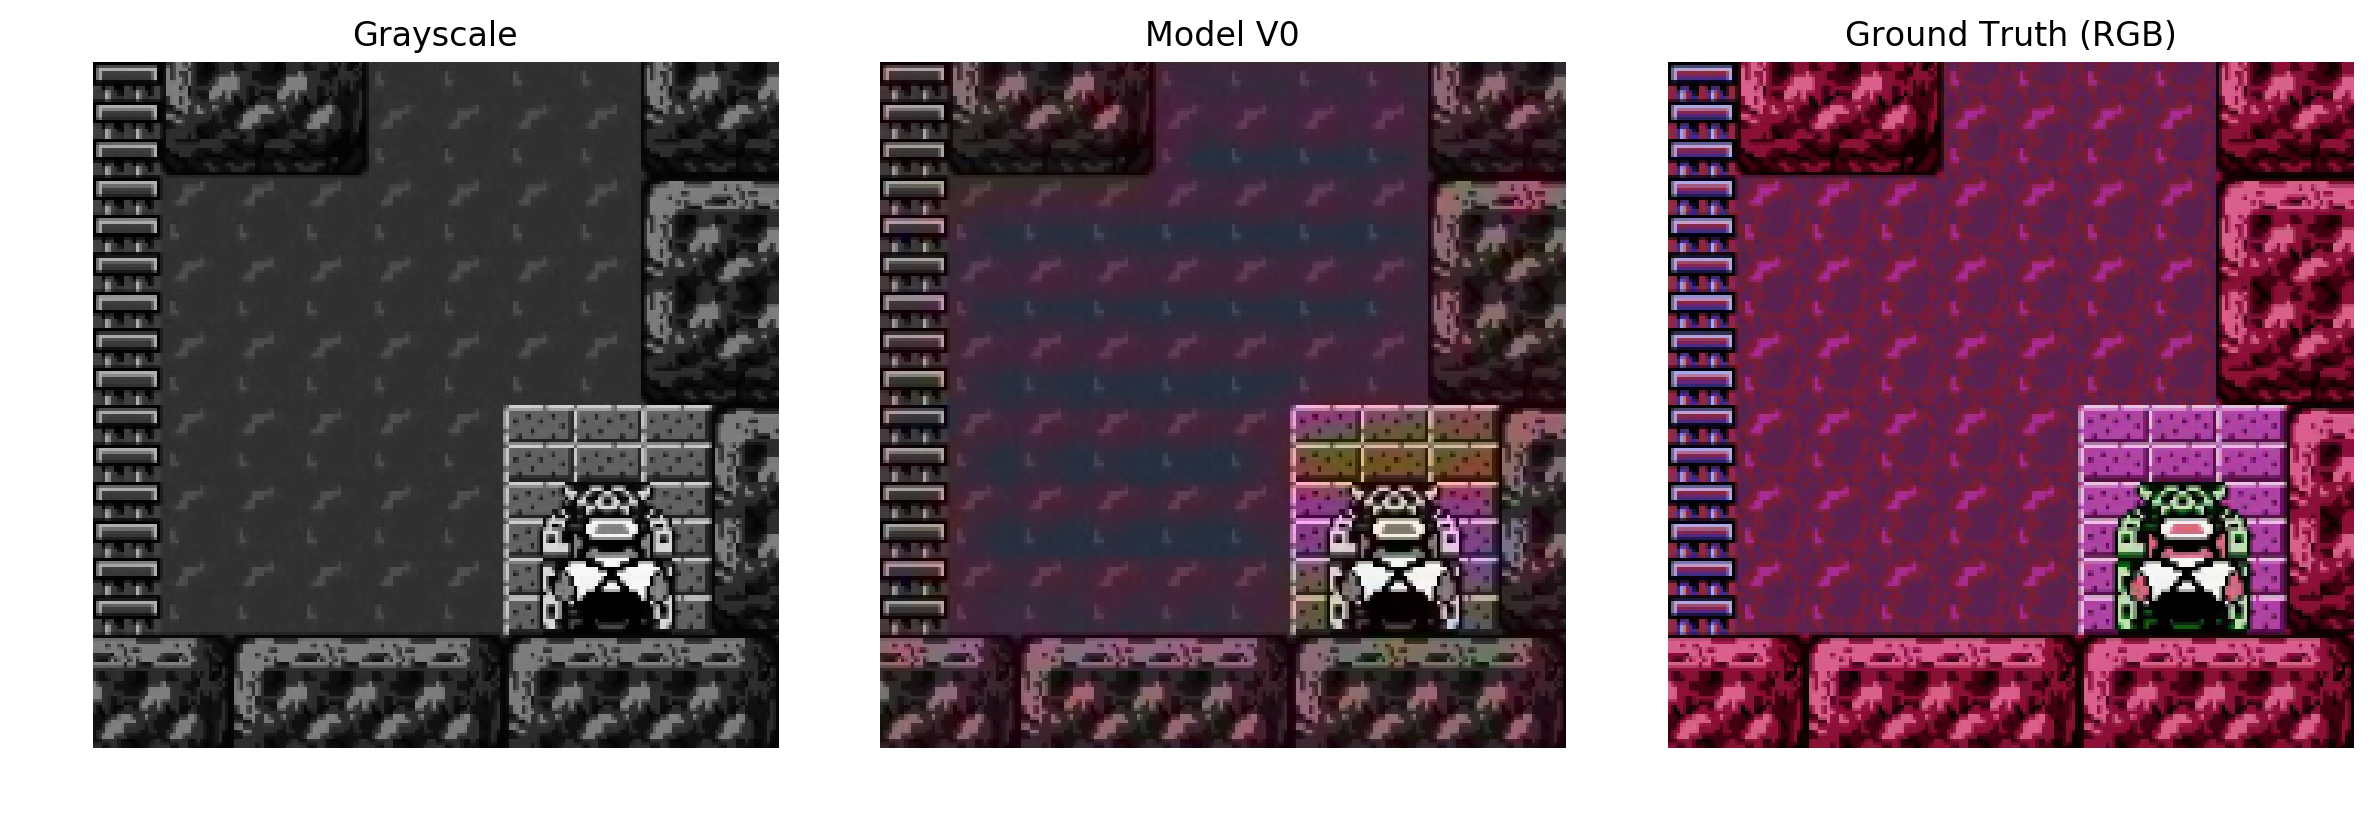

In [23]:
show_model_results(model, 
                   model_name='Model V0', 
                   lab_version=checkpoint['lab_version'], 
                   path=get_random_file('images/valid/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)

### V1 small

In [9]:
# specify an output path
prefix = 'model_v1'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train_color_cnn.py',
                    source_dir='aws', 
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'model-version': 'ColorCNN_v1_small',
                        'lab-version': 1
                    })

In [ ]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

2020-04-14 16:14:21 Starting - Starting the training job...
2020-04-14 16:14:23 Starting - Launching requested ML instances......
2020-04-14 16:15:23 Starting - Preparing the instances for training.........
2020-04-14 16:17:02 Downloading - Downloading input data.........
2020-04-14 16:18:38 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-14 16:19:33,887 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-14 16:19:33,913 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-14 16:19:33,917 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-14 16:19:34,241 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-04-14 16:19:34,241 sagemaker-containers INFO     Generating setup.cfg
2020-04-14 16:1

In [34]:
# specify all the paths 
DEST_PATH = 'results/model_v1'
FROM_PATH = 'model_v1_lab2/pytorch-training-2020-04-10-21-58-34-426/output/model.tar.gz'
TO_PATH = os.path.join(DEST_PATH, 'model.tar.gz')
CHECKPOINT_PATH = os.path.join(DEST_PATH, 'model_best.pth.tar')

os.makedirs(DEST_PATH)

In [8]:
# specify an output path
prefix = 'model_v0_lab2'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train_v0.py',
                    source_dir='aws', 
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 50,
                        'lab-version': 2
                    })

In [ ]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

In [34]:
# specify all the paths 
DEST_PATH = 'results/model_v0_lab2'
FROM_PATH = 'model_v0_lab2/pytorch-training-2020-04-10-21-58-34-426/output/model.tar.gz'
TO_PATH = os.path.join(DEST_PATH, 'model.tar.gz')
CHECKPOINT_PATH = os.path.join(DEST_PATH, 'model_best.pth.tar')

os.makedirs(DEST_PATH)

In [38]:
# download the data from S3
boto3.resource('s3').Bucket(bucket).download_file(FROM_PATH, TO_PATH)

# unpack the zip 
shutil.unpack_archive(TO_PATH, DEST_PATH)

# load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))

# instantiate the model and load the state dict for inference
model = ColorCNN_v0(lab_version=checkpoint['lab_version']).to(device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

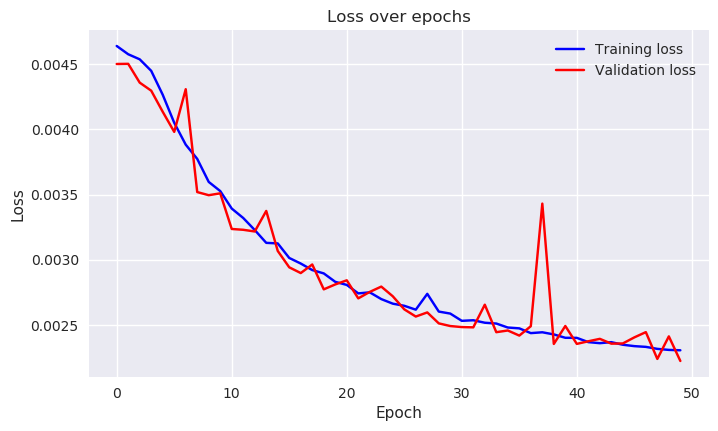

In [40]:
# plot the losses 
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']
plot_losses(train_losses, valid_losses)

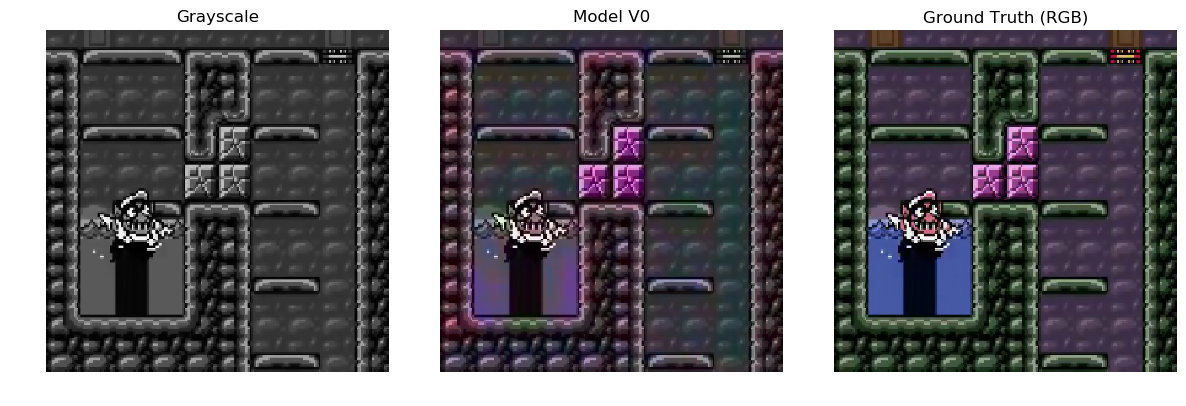

In [66]:
show_model_results(model, 
                   model_name='Model V0', 
                   lab_version=checkpoint['lab_version'], 
                   path=get_random_file('images/valid/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)

In [38]:
# download the data from S3
boto3.resource('s3').Bucket(bucket).download_file(FROM_PATH, TO_PATH)

# unpack the zip 
shutil.unpack_archive(TO_PATH, DEST_PATH)

# load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))

# instantiate the model and load the state dict for inference
model = ColorCNN_v0(lab_version=checkpoint['lab_version']).to(device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

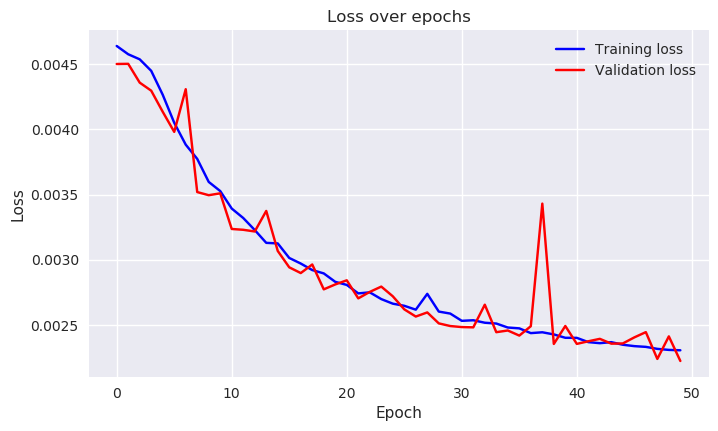

In [40]:
# plot the losses 
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']
plot_losses(train_losses, valid_losses)

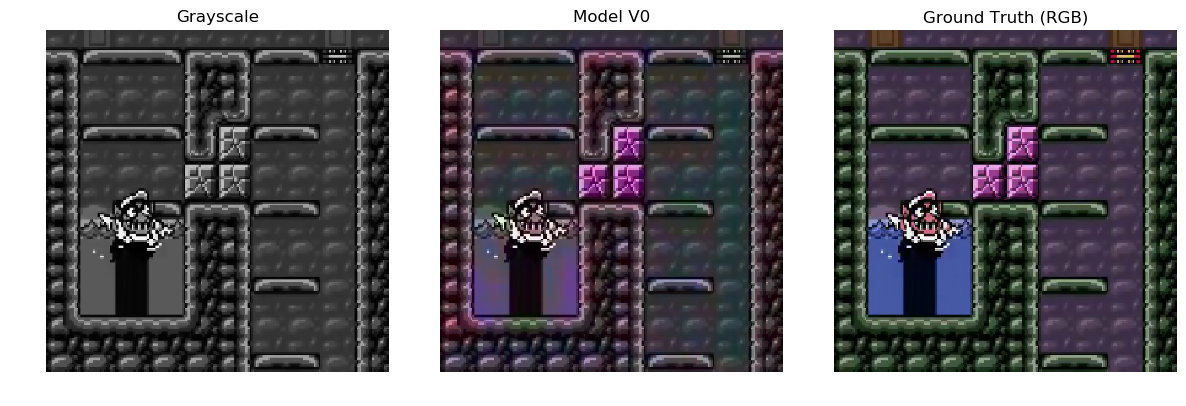

In [66]:
show_model_results(model, 
                   model_name='Model V1', 
                   lab_version=checkpoint['lab_version'], 
                   path=get_random_file('images/valid/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)

## Deploying the model for inference

In [16]:
estimator.model_data

's3://sagemaker-eu-west-1-873555039102/model_v0/pytorch-training-2020-04-09-22-55-08-370/output/model.tar.gz'

In [ ]:



# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='source_solution')

In [ ]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

In [ ]:
s3://bucketname/image_folder